In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm  #
from typing import Callable

from classes.AlexNet import AlexNet


from utils.functions import plot_confusion_matrix, load_cifar10

In [24]:

# define model parameters
NUM_EPOCHS = 90  # original paper
BATCH_SIZE = 32
MOMENTUM = 0.9
LR_DECAY = 0.0005
LR_INIT = 0.01
IMAGE_DIM = 227  # pixels
NUM_CLASSES = 100  # 1000 classes for imagenet 2012 dataset
DEVICE_IDS = [0, 1, 2, 3]  # GPUs to use

CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog']


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [26]:
# Defina as transformações para redimensionar e normalizar as imagens
transform = transforms.Compose([transforms.Resize((IMAGE_DIM, IMAGE_DIM)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [27]:
trainset, testset = load_cifar10(n_size=1, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [28]:
# Defina o dataloader
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)


In [29]:

# Instancie a AlexNet
alexnet = AlexNet().to(device)


In [30]:
# Defina a função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet.parameters(), lr=0.01, momentum=0.9)
# Treine a rede
num_epochs = 2
train_losses = []
test_losses = []

In [31]:

for epoch in range(num_epochs):
    alexnet.train()
    running_loss = 0.0
    tqdm_trainloader = tqdm(trainloader, desc=f'Epoch {epoch+1}/{num_epochs}, Training', dynamic_ncols=True)

    for i, data in enumerate(tqdm_trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Mova os dados para o dispositivo correto

        optimizer.zero_grad()

        outputs = alexnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        tqdm_trainloader.set_postfix({'loss': running_loss / (i + 1)})

    # Calcule a perda média no conjunto de treinamento
    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)

    # Avalie o modelo no conjunto de teste
    alexnet.eval()
    running_test_loss = 0.0
    tqdm_testloader = tqdm(testloader, desc=f'Epoch {epoch+1}/{num_epochs}, Testing', dynamic_ncols=True)

    with torch.no_grad():
        for data in tqdm_testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Mova os dados para o dispositivo correto

            outputs = alexnet(inputs)
            test_loss = criterion(outputs, labels)
            running_test_loss += test_loss.item()

    # Calcule a perda média no conjunto de teste
    test_loss = running_test_loss / len(testloader)
    test_losses.append(test_loss)

    tqdm_trainloader.set_postfix({'Training Loss': train_loss, 'Testing Loss': test_loss})
    tqdm_trainloader.close()
    tqdm_testloader.close()

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


Epoch 1/2, Testing: 100%|██████████| 4/4 [00:01<00:00,  3.27it/s]


Epoch 1/2, Training Loss: 2.3026, Test Loss: 2.3033


Epoch 2/2, Testing: 100%|██████████| 4/4 [00:01<00:00,  3.31it/s]

Epoch 2/2, Training Loss: 2.2999, Test Loss: 2.3057


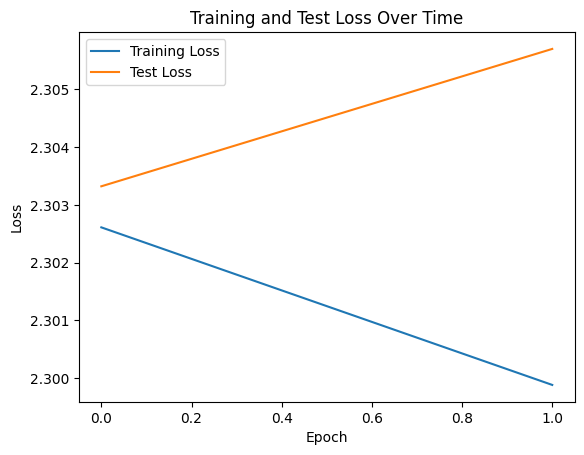

In [32]:
# Plote gráficos de perda
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Time')
plt.show()


In [34]:
plot_confusion_matrix(alexnet, trainloader, CIFAR10_CLASSES,device,'train')

Generating Confusion Matrix:  44%|████▍     | 7/16 [00:03<00:04,  2.04it/s]

In [ ]:
plot_confusion_matrix(alexnet, testloader, CIFAR10_CLASSES, device,'test')

Generating Confusion Matrix: 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]